# *Import Libraries and perform Data Preprocessing*

In [1]:
# STEP 1: Install necessary library
!pip install yfinance --quiet

In [51]:
# STEP 2: Import libraries
import yfinance as yf
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [3]:
# STEP 3: Load stock data
ticker = 'AAPL'
df = yf.download(ticker, start='2022-01-01', end='2024-01-01')
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df.dropna(inplace=True)

/tmp/ipython-input-3-3307097659.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2022-01-01', end='2024-01-01')
[*********************100%***********************]  1 of 1 completed


# *Data visualization*

In [11]:
df.head()

Price,Open,High,Low,Close,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2022-01-03,174.542932,179.499589,174.425155,178.645660,104487900
2022-01-04,179.254190,179.558457,175.809061,176.378342,99310400
2022-01-05,176.290033,176.839679,171.411899,171.686722,94537600
2022-01-06,169.507721,172.059668,168.467317,168.820663,96904000
2022-01-07,169.694226,170.921120,167.868606,168.987534,86709100


In [4]:
df.describe()

Price,Open,High,Low,Close,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,501.000000,501.000000,501.000000,501.000000,5.010000e+02
mean,161.460145,163.288978,159.788979,161.620328,7.359234e+07
std,17.813390,17.512542,18.043880,17.781002,2.536511e+07
min,124.398589,126.136083,122.582127,123.421249,2.404830e+07
25%,146.716186,148.842087,145.348158,147.230209,5.414710e+07
50%,162.136743,163.731955,160.200681,162.529846,6.924600e+07
75%,174.542932,176.057069,172.656490,174.569946,8.670910e+07
max,196.580427,198.168786,195.567834,196.669769,1.826020e+08


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 501 entries, 2022-01-03 to 2023-12-29
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Open, AAPL)    501 non-null    float64
 1   (High, AAPL)    501 non-null    float64
 2   (Low, AAPL)     501 non-null    float64
 3   (Close, AAPL)   501 non-null    float64
 4   (Volume, AAPL)  501 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 23.5 KB


In [7]:
df.shape

(501, 5)

In [10]:
df.columns

MultiIndex([(  'Open', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            ( 'Close', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])

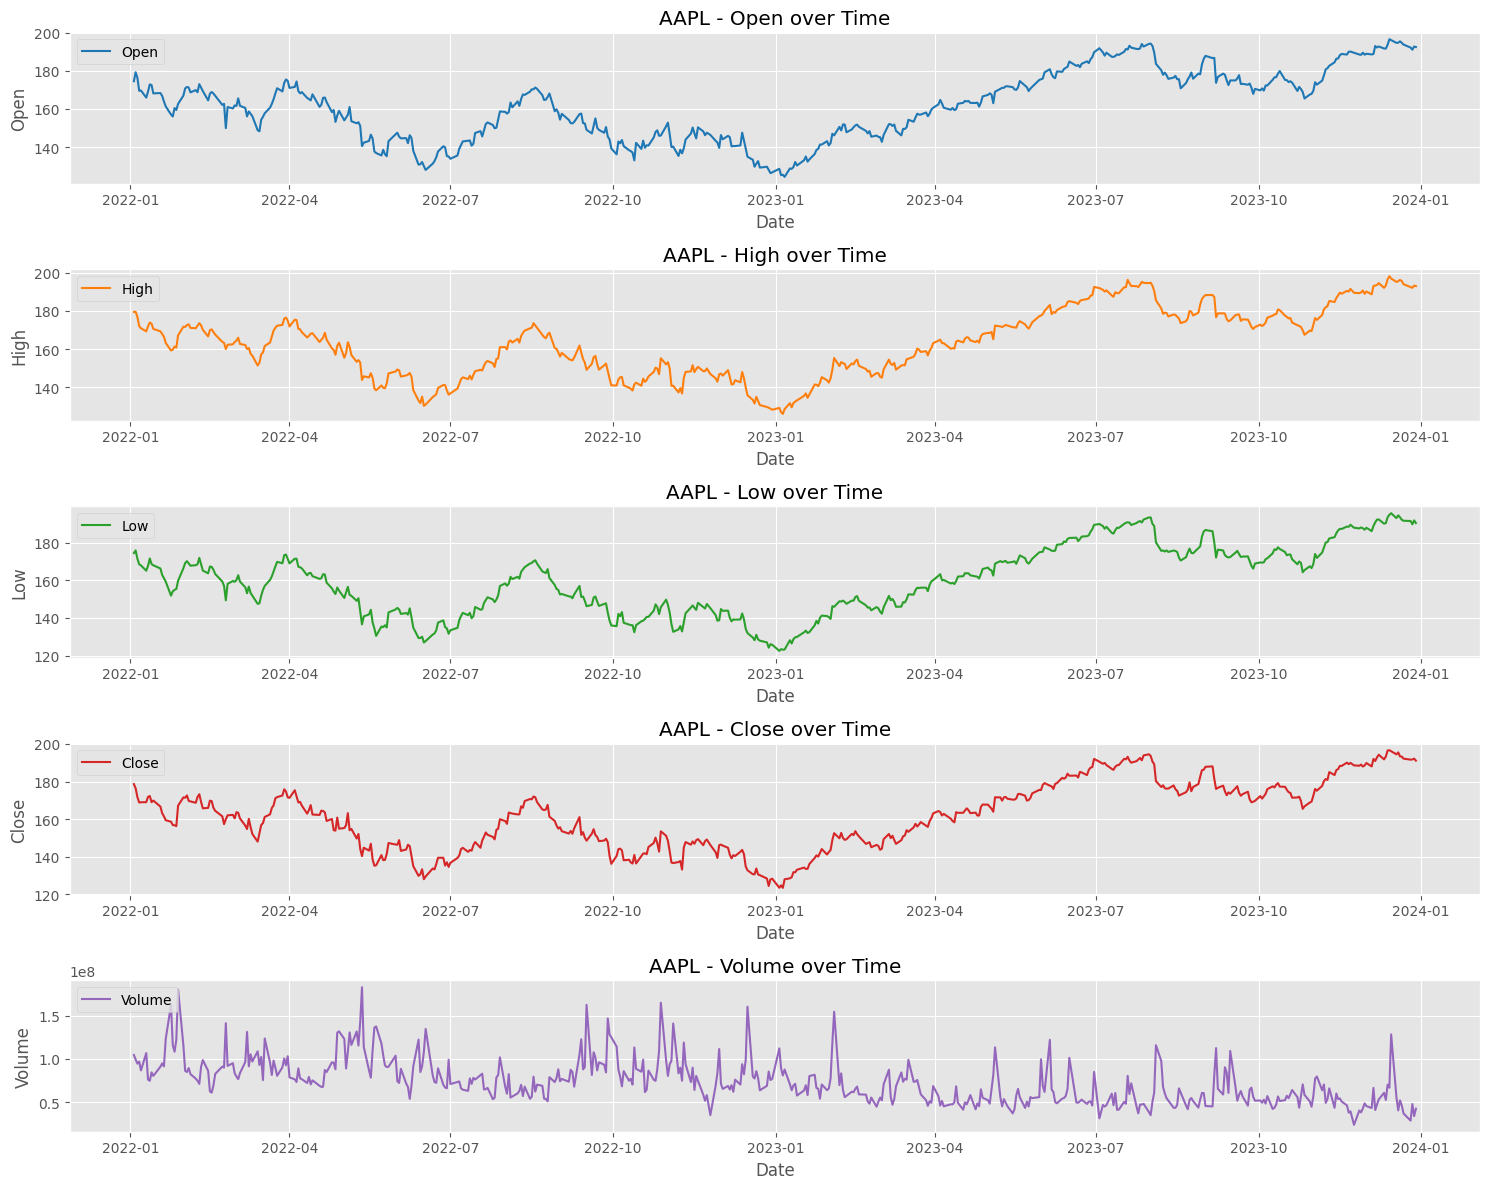

In [28]:
# Set style
plt.style.use('ggplot')

# Plot each column as individual time series
plt.figure(figsize=(15, 12))

columns = ['Open', 'High', 'Low', 'Close', 'Volume']

for i, col in enumerate(columns):
    plt.subplot(len(columns), 1, i + 1)
    plt.plot(df[col], label=col, color=sns.color_palette("tab10")[i])
    plt.title(f"{ticker} - {col} over Time")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

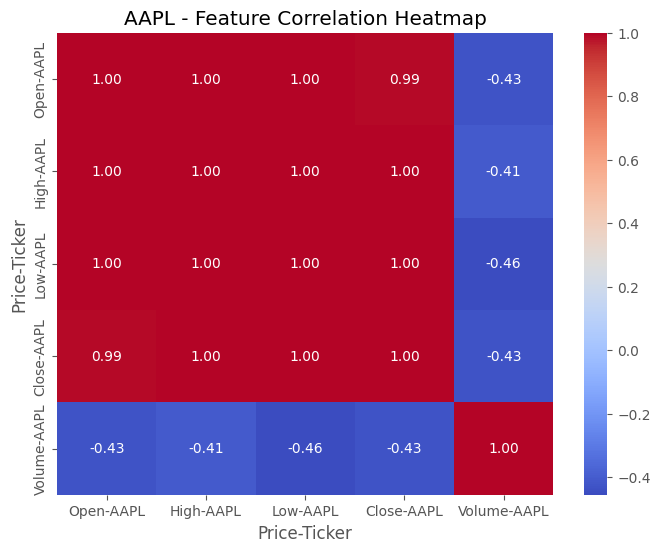

In [29]:
# Correlation matrix
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title(f'{ticker} - Feature Correlation Heatmap')
plt.show()

In [32]:
!pip install plotly --quiet

In [33]:
import plotly.graph_objects as go
import plotly.express as px


In [36]:
# Ensure datetime index
# Access columns using the MultiIndex
df = df.dropna(subset=[('Open', ticker), ('High', ticker), ('Low', ticker), ('Close', ticker)])
df = df.copy()
df['Date'] = df.index  # Move datetime index to a column

# Plotly candlestick chart with fixes
fig = go.Figure(data=[go.Candlestick(
    x=df['Date'],
    open=df[('Open', ticker)],
    high=df[('High', ticker)],
    low=df[('Low', ticker)],
    close=df[('Close', ticker)],
    increasing_line_color='green',
    decreasing_line_color='red'
)])

fig.update_layout(
    title=f'{ticker} Candlestick Chart',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    xaxis_rangeslider_visible=True,
    template='plotly_dark'
)

fig.show()

# *LSTM model training*

In [71]:
# STEP 5: Normalize features
scaler = MinMaxScaler()
# Drop the 'Date' column before scaling as it's not numerical
scaled_data = scaler.fit_transform(df.drop('Date', axis=1))

/tmp/ipython-input-71-2726385231.py:4: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [72]:
# STEP 6: Create sequences for LSTM
def create_sequences_multivariate(data, seq_length=180):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 3])  # Index 3 = 'Close'
    return np.array(X), np.array(y)

In [75]:
sequence_length = 180
X, y = create_sequences_multivariate(scaled_data, seq_length = 180)

In [76]:
# STEP 7: Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [77]:
# STEP 8: Build the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [78]:
history = model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - loss: 0.1391
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 0.0155
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 0.0129
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - loss: 0.0117
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - loss: 0.0090
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - loss: 0.0095
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 0.0087
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 0.0083
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - loss: 0.0071
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - loss: 0.0068
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - loss: 0.0082
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - loss: 0.0070
Epoch 13/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.0066
Epoch 14/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - loss: 0.0071
Epoch 15/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 0.0080
Epoch 16/20
8/8 ━━━

In [79]:
# STEP 9: Make predictions
predicted_scaled = model.predict(X_test)
predicted_full = np.zeros((predicted_scaled.shape[0], scaled_data.shape[1]))
predicted_full[:, 3] = predicted_scaled[:, 0]  # Fill only the Close column

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step


In [81]:
# Reverse scale only Close values
actual_scaled = np.zeros((len(y_test), scaled_data.shape[1]))
actual_scaled[:, 3] = y_test

In [82]:
predicted_prices = scaler.inverse_transform(predicted_full)[:, 3]
actual_prices = scaler.inverse_transform(actual_scaled)[:, 3]

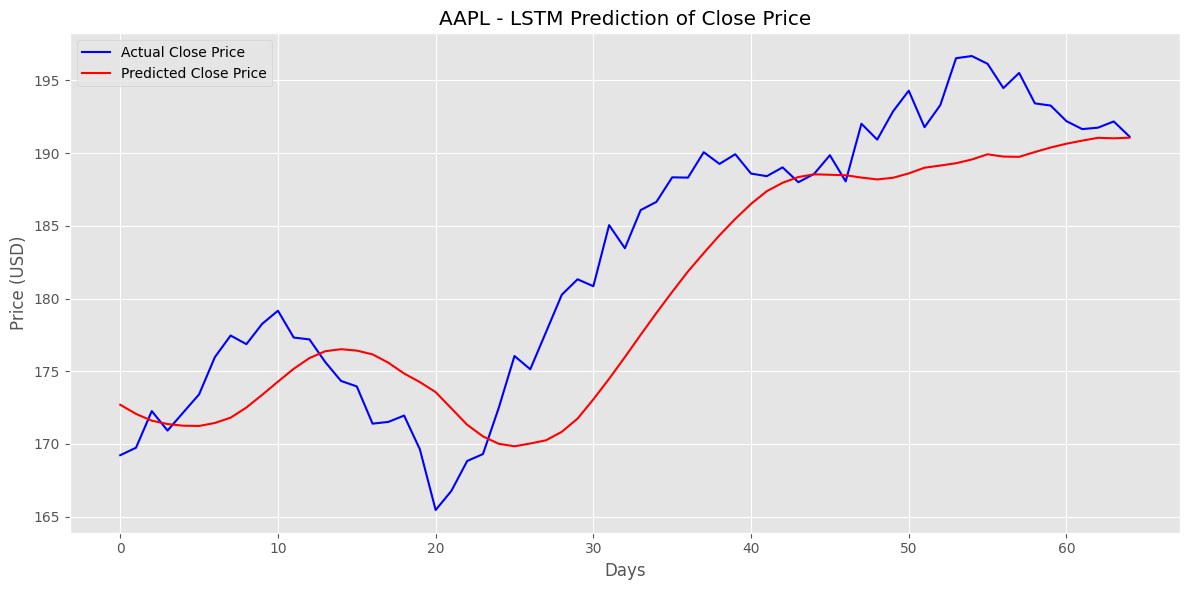

In [83]:
# STEP 10: Visualize predictions vs actual
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual Close Price', color='blue')
plt.plot(predicted_prices, label='Predicted Close Price', color='red')
plt.title(f'{ticker} - LSTM Prediction of Close Price')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [84]:
mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
r2 = r2_score(actual_prices, predicted_prices)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

MAE: 4.02
RMSE: 4.85
R² Score: 0.7217


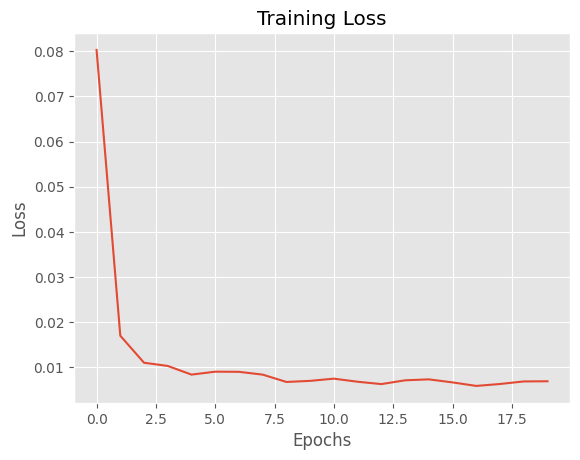

In [85]:
# Plot training loss
plt.plot(history.history['loss'])
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()